<a href="https://colab.research.google.com/github/didemdurukan/Bachlors-Project/blob/master/image_classification_shared_orig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on notebok: Image classification with the CIFAR-10 data set

With this notebook we load and preprocess image data, build and train a neural network, evaluate its preformance, tune the model (train it again...) and finally predict on an unseen test set. 

Note: all the code should run without any modifications. However, there are several placeholders for you to change code and improve the neural network




### (1) Import libraries and set up notebook

In [ ]:
# import tensorflow and verify tf version (expected as of 11/15: 2.7.0)
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split

In [ ]:
%%capture
!pip install tensorflow_addons
import tensorflow_addons as tfa

In [ ]:
# To utilize GPU: Go to Runtime -> Change runtime type -> Hardware accelerator: GPU
# (you'll need to rerun the previous cell as this restarts the kernel)
# verify that GPU is used:
tf.config.list_physical_devices('GPU')


### (2) Load data and preprocess data

We use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) data from [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). This is a labelled dataset with images of objects belonging to 10 different categories such as truck, ship, bird, deer etc. It has 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images..

To preprocess and augment the data we use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#fit).


In [ ]:
# load fashion_mnist data from tf.keras.datasets as numpy arrays
(x_train0, y_train0), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# lets also create a validation set to avoid overfitting on the test set when training/tuning the model
x_train, x_val, y_train_, y_val_ = train_test_split(x_train0, y_train0, test_size = 0.2, stratify=y_train0)

In [ ]:
# reshape pictures and labels for the ImageDataGenerator and the model

# reformat y (labels) for multiclass categorization:
y_train = tf.keras.utils.to_categorical(y_train_)
y_val = tf.keras.utils.to_categorical(y_val_)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# the labels correspond to the following categories:
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [ ]:
# Lets take a look at some example pictures:

n_pics = 30  # select number of pictures to show (use mutiple of 10)

plt.figure(figsize=(12, 1.5*int(n_pics/10)))
for i in range(n_pics):
  plt.subplot(int(n_pics/10),int(n_pics/(n_pics/10)),i+1)
  plt.title(label_dict[y_train_[i][0]])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i,:,:])
plt.tight_layout()
plt.show()

In [21]:
# Now, let's use the ImageDataGenerator to augment data while streaming from memory
# Note: the ImageDataGenerator can also be used to stream large amounts of data driectly disk (not ideal for Goolge Drive)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# specify batch size that will be used during training and inference 
# e.g batch_size=10 means 10 pictures are evaluated together before weights are updated
# if you choose the batch size too large, you might run into memory issues
BATCH_SIZE = 10

# ToDo: uncomment and complete parameters to experiment with data augmentation
data_gen_train = ImageDataGenerator(
    rescale=1/255.0,            # rescale pixel values to the range 0-1
    rotation_range=60,       # Int: Degree range for random rotations. 
    zoom_range=0.2,           # Float: Range for random zoom
    shear_range=0.2,          # Float: Shear Intensity
    width_shift_range=0.3,    # Float: fraction of total width 
    height_shift_range=0.3,   # Float: fraction of total height
    horizontal_flip=True,      # Boolean: Randomly flip inputs vertically
)
train_genenerator = data_gen_train.flow(x_train, y_train, batch_size=BATCH_SIZE)

# Note: for validation & test data, we omit data augmentation
data_gen_val = ImageDataGenerator(rescale=1/255.0)
validation_genenerator = data_gen_val.flow(x_val, y_val, batch_size=BATCH_SIZE)
data_gen_test = ImageDataGenerator(rescale=1/255.0)
test_genenerator = data_gen_test.flow(x_test, y_test, batch_size=BATCH_SIZE)

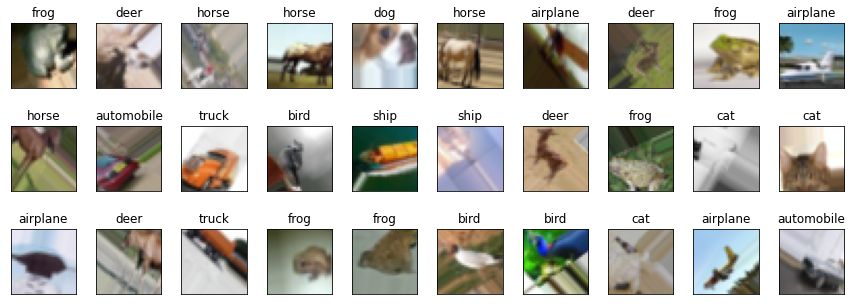

In [22]:
# Now, with data augmentation, lets again take a look at some sample pictures:

n_pics = 30  # select number of pictures to show (use mutiple of 10)

plt.figure(figsize=(12, 1.5*int(n_pics/10)))
for i, pic in enumerate(train_genenerator):
  if i < n_pics:
    pic_ = pic[0][0,:,:,:]
    plt.subplot(int(n_pics/10),int(n_pics/(n_pics/10)),i+1)
    plt.title(label_dict[np.argmax(pic[1])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pic_)
  else: 
    break
plt.tight_layout()
plt.show()

### (3) Build and train the neural network

We use the [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) from tf.keras to build the neural network. Build it by creating a linear stack of some of the following layers:


*   [InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer): instantiate the tf.keras tensor with the correct shape
*   [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): 2-dimensional convolutional layer for images. Specify the number of filters and the kernel size
*   [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Compress 2D spatial data. Specify the pool_size (e.g. pool_size=(2,2) compressess a 28x28 image to 14x14
*   [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): Flatten a 2/3-dimensional input (e.g. image or output of a convolutional lauer) into a 1-dimensional vector that can be used as input for a dense layer
*   [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Regular densely connected neural network layer. Note: the output layer must be a Dense layer with the number of units corresponding to the output dimension (=number of categories to predict) and a [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) activation




In [28]:
# define model: the model below works but can be improved. Play around with parameters and add additional layers
# to see if you can improve accuracy while training
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),   # do not change the input layer
    # ToDo: add Conv/MaxPool2D layers:
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu',padding="same"), # ToDo: use various filters, kernel_sizes
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu',padding="same"), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu',padding="same"), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu',padding="same"), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),   # do not change/remove this layer 
    # ToDo: change number of units, add additional dense layers:
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax') # do not change the output layer
])

# check out the model summary and see if the number of model parameters make sense to you
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 10)        910       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 10)         0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 10)          910       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 4, 4, 10)        

In [ ]:
# Setup callback to allow training evaluation with TensorBoard

# Clear any logs from previous runs
! rm -rf ./logs/

# Specify tensorboard_callback for visualizations
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

When compiling the model, we specify the loss, metrics and optimizer. Try out some of the following optimizers:


*   [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD): stochastic gradient descent
*   [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop): Root Mean Square Propagation
*   [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam): Adaptive Moment Estimation

In [ ]:
N_EPOCHS = 5    # number of iterations through entire dataset, ToDo: change for longer/shorter training 
LEARNING_RATE = 1e-3

# Define the optimizer. ToDo: try different optimizers / learning rates ...
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model with specified optimizer, loss and validation metrics:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_genenerator, validation_data=validation_genenerator, epochs=N_EPOCHS,
                    verbose=1, callbacks=[tensorboard_callback])

### (4a) Evaluate training performance (conventional)

Run the code below to assess your model performance, if you are not satisfied with the validation accuracy, go back to (3), modify your model and train again. Use the plot for validation performance to see if longer/shorter training might improve your results.

In [ ]:
# Calculate the training and validation loss and accuracy with your trained model (tf performs inference on training/validation set)
# If your validation accuracy << 0.9, see if you can improve the model
print('Inference on training set:')
train_loss, train_acc = model.evaluate(train_genenerator)
print('Inference on validation set:')
val_loss, val_acc = model.evaluate(validation_genenerator)

In [ ]:
# Plot the history of training and validation performance
# Note: 
# - if validation prerformance keeps increasing, longer training (more epochs) might further improve the model
# - if validation performance starts decreasing (while training performance keeps increasing) you might be overfitting
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], label='training set')
plt.plot(history.epoch, history.history['val_loss'], color='orange', label='validation set')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], label='training set')
plt.plot(history.epoch, history.history['val_accuracy'], color='orange', label='validation set')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# Check out your prediction on some random validation set images 

n_pics = 60  # select number of random val-set pictures to predict (use mutiple of 10)

plt.figure(figsize=(15, 1.5*int(n_pics/10)))
for i1 in range(n_pics):
  i = np.random.randint(len(y_val))
  # x = np.expand_dims(np.expand_dims(x_val[i,:,:], 0), -1)
  x = np.expand_dims(x_val[i,:,:,:], 0)
  label_pred = label_dict[np.argmax(model.predict_step(x))]
  plt.subplot(int(n_pics/10),int(n_pics/(n_pics/10)),i1+1)
  plt.imshow(x_val[i,:,:,:])
  plt.title('pred.: {}, \n true: {}'.format(label_pred, label_dict[np.argmax(y_val[i])]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

### (4b) Evaluate the training performance with the [TensorBoard](https://www.tensorflow.org/tensorboard)

TensorBoard is a toolkit to visualize the TF Graph, metrics and parameters during model training. Explore it and navigate among the following tabs:
*   SCALARS: Explore accuracy & loss during training
*   GRAPHS: Take a look at the TensorFlow Graph of your model and see if you cn understand it
*   DISTRIBUTIONS: See how the distributions of your model parameters changed over epochs during training
*   HISTOGRAMS: See the histograms of distributions of your model parameters during training






In [ ]:
# Load the TensorBoard notebook extension and display the TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

### (5) Predict on test data

Finally, after you are satisfied with your model based on training/validation performance, evaluate the performance on the test set. If you didn't overfit on the validation set, the accuracy should be similar as with prediction on the validation set.

In [ ]:
test_loss, test_acc = model.evaluate(test_genenerator)
print('\nFinal accuracy achieved on test set:', np.round(test_acc, 3))

## OPTIONAL Advanced topic: Using Transfer Learning


What is Transfer Learning? It is basically magical **Knowledge Transfer**!! It is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones. In transfer learning, we can leverage knowledge (features, weights etc) from previously trained models for training newer models and even tackle problems like having less data for the newer task! 

A very good and more extensive explanation of Tranfer Learning can be found in the blog post [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)!

In our case, we will leverage [MobileNetV2](https://arxiv.org/abs/1801.04381) trained on the famous [Imagenet](https://www.image-net.org/about.php) dataset.




In [ ]:
# let's load the pretrained network

base_model = tf.keras.applications.MobileNetV2(
        input_shape=(96,96,3),
        include_top=False,
        weights="imagenet",
    )

base_model.summary()

In [ ]:
# freeze the convolutional base to retain info and speed up training
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Resizing(96, 96)(inputs) # add this to resize our input to waht the pretrained  mobilenet expects
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model_tl = tf.keras.Model(inputs, outputs)

In [ ]:
# check the new model
model_tl.summary()

In [ ]:
# set up the data generators
BATCH_SIZE = 20

# train data augmentation
data_gen_train = ImageDataGenerator(
    rescale=1/255.0,            
    horizontal_flip=True      
)
train_genenerator = data_gen_train.flow(x_train, y_train, batch_size=BATCH_SIZE)

data_gen_val = ImageDataGenerator(rescale=1/255.0)
validation_genenerator = data_gen_val.flow(x_val, y_val, batch_size=BATCH_SIZE)

data_gen_test = ImageDataGenerator(rescale=1/255.0)
test_genenerator = data_gen_test.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
#training
N_EPOCHS = 3    

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3.0e-4)

# some callbacks you can you to monitor training
model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5, verbose=1,restore_best_weights=False)


# Compile the model with the specified optimizer with clr, loss and validation metrics:
model_tl.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes= 10,average="weighted")])

history_tl = model_tl.fit(train_genenerator, validation_data=validation_genenerator, epochs=N_EPOCHS,
                    verbose=1, callbacks=[model_early_stopping_callback])

Let's evaluate the performance on all sets.

In [ ]:
print('Inference on training set:')
train_loss, train_acc, train_f1 = model_tl.evaluate(train_genenerator)
print('Inference on validation set:')
val_loss, val_acc, val_f1 = model_tl.evaluate(validation_genenerator)
print('\nInference on test set:')
test_loss, test_acc, test_f1 = model_tl.evaluate(test_genenerator)


## OPTIONAL Advanced topic: Using an LR scheduler

We have seen how Learning Rate ("LR") can influence the performance of our network. Small LRs hinder performance of the network as the slow down training and can also get stuck at local optima or saddle points of the loss landscape, while big LRs hop around our space never converging. 

This triggers the following two questions:
* How can we find an optimal (fixed) LR to train our model
* Is there a way to decrease the risk getting stuck at a local optima without having to use a LR that is too large for optimal performance?

In this section, we show two separate applications of a learning rate scheduler to tackle these questions:
 * LearningRateSchedule: How to use it in a callback to find the best fixed LR for training 
 * Cyclical LR: How to apply a changing LR to a SGD optimizer to improve training

Additional Resource: We highly recommend reading [this](https://www.jeremyjordan.me/nn-learning-rate/) article by Jeremy Jordan, where he explains in detail how setting the learning rate of your network correctly affects the performance of your training and how a LR scheduler can help almost eliminate the need to fine tune this parameter.

### Example 1: Learning rate scheduler to find the best learning rate

In this example, we show how you can levarage the [LearningRateSchedule](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) from tf.keras as a callback to find the best LR for a given optimizer (e.g. SGD). We assume that the best LR is the highest one that does not yet lead to an increase in variance of the loss during training.

In [ ]:
model_adv = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# set up the data generators
BATCH_SIZE = 20

train_genenerator = data_gen_train.flow(x_train, y_train, batch_size=BATCH_SIZE)
validation_genenerator = data_gen_val.flow(x_val, y_val, batch_size=BATCH_SIZE)
test_genenerator = data_gen_test.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
# Create the learning rate scheduler with a learning rate that is increasing with each epoch
# (from 1e-5 at epoch 0 to 1 at epoch 50)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 10))

# set the learning rate as the starting point of the learning rate scheduler:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

model_adv.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# pass the learning rate scheduler as callback when fitting the model:
history = model_adv.fit(x_train, y_train, epochs=50, callbacks=lr_schedule)

In [ ]:
first_epoch_in_plot = 1
plt.plot(history.history['lr'][first_epoch_in_plot:], history.history['loss'][first_epoch_in_plot:])
plt.xscale('log')
plt.title('Learning rate schduler - loss vs. learning rate')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

You should see that we find an optimal learning rate somewhere between 1e-1 and 5e-3. Use this learning rate as a "best guess" to start training your model from scratch

### Example 2: Cyclical Learning rate

In the following model, we implement one of these schedulers called [Cyclical Learning Rate](https://arxiv.org/abs/1506.01186). Here we are using the [CyclicalLearningRate](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/CyclicalLearningRate) class from tensorflow_addons 

As opposed to the previous example, where we aimed to find the best learning rate for subsequent re-training, the objective of this example is to improve training directly with a variable learning rate.

After you run the following model to see how it works, copy paste the Cyclical LR cell to your own created network above and see how it effects your training performance!

In [ ]:
# let's reset the same model as above

model_adv = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
#### Cyclical LR part from here ####

N_EPOCHS = 20    # number of iterations through entire dataset

#set these 
MIN_LR = 5e-3
MAX_LR = 1e-1

# initialize the cyclical learning scheduler
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * BATCH_SIZE
  )
optimizer = tf.keras.optimizers.SGD(clr)


Let's see what that scheduler does to our LR during training:

In [ ]:
step = np.arange(0, N_EPOCHS * BATCH_SIZE)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:

# some callbacks you can you to monitor training
model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=10, verbose=1,mode = "max", restore_best_weights=False)


# Compile the model with the specified optimizer with clr, loss and validation metrics:
model_adv.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes= 10,average="weighted")])

history_adv = model_adv.fit(train_genenerator, validation_data=validation_genenerator, epochs=N_EPOCHS,
                    verbose=1, callbacks=[model_early_stopping_callback])

In [ ]:
# evaluate on train and val sets
print('Inference on training set:')
train_loss, train_acc, train_f1 = model_adv.evaluate(train_genenerator)
print('Inference on validation set:')
val_loss, val_acc, val_f1 = model_adv.evaluate(validation_genenerator)

In [ ]:
# evaluate on test data

test_loss, test_acc, test_f1 = model_adv.evaluate(test_genenerator)
print('\nFinal accuracy achieved on test set:', np.round(test_acc, 3))